In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from IPython.display import Image
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resultattsne/Capture.PNG
/kaggle/input/mobile-net-architecture/MobileNetV2 architecture.png
/kaggle/input/results/Capture.PNG
/kaggle/input/unet-architecture/u-net-architecture.png


In [4]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import cv2

from sklearn.manifold import TSNE
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import Recall, Precision, BinaryCrossentropy
from tensorflow.keras import backend as K

I had several projects in my internship in Sweden and one of them was to implement a model able to have a visual classifification of unlabeled defects pictures from the industrial process called additive manufacturing. I leave here a link about the process : https://www.youtube.com/watch?v=t4S0mKjXtT4

The goal of this notebook is to show you my a little about my work in Sweden. 

I had two Dataset of pictures : one from a camera at 90° about the tray and an other from a camera based on the optical tomography technology with a little angle this time. Those optical tomography (OT) pictures works as a thermal camera : it is red when the area represents a defect (depending on the threshold used by the operator) and blue when the part does not. I have not the right to use the pictures and the statistics table of all the steps of my work but the goal of this notebook is to show you what I did in Sweden overall.

The idea here was to use an pre-trained encoder feed by the camera pictures and the OT pictures to decode the defect pictures. The encoder enabled me to extract the main features of the pictures and the decoder to assert if those features extracted are great or not. Then, I used TSNE on the output from the encoder for visualization in order to see if there is some clusters or not and more important, if each cluster represents a particular defect. Hopefully, the result was great (each dot represent a picture) and checked by the experts of additive manufacturing :

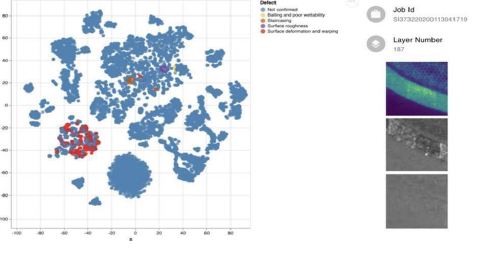

In [5]:
Image("../input/results/Capture.PNG")

# Preprocessing of the pictures

**The issues here is to import and crop the pictures. Then, we will have to focus the pictures on the defected area. For that, I will use the work I had done before this mission which was to define the defects with some statistics. One of those statistics are the surface and the boundaries of the defected area. Knowing that, it is simpler to succeed on this task. Finally, I have to change the perspective of the OT pictures. Previously, I wrote that the OT camera take pictures not perfectly vertically, unlike the "normal" camera, and it exists a little angle. I solved this problem by using a perspective matrix. To image my statement, you could make a parallel with the scanner application on your smartphone which change the perspective of your picture to have the document in front of you. I could say that 90% of the difficulty was in this part. In fact, importing the pictures was really tricky because they were spread in different files with different names and for the statistics, sometimes, there was some missing values and columns which was the problem from the API of the 3D printer. You could see below this long work on the preprocessing.**

***Importation of the pictures and the statistic tables (for each job). As you can see a lot of work just for importing the pictures... It is due to the fact that every job are on a different file so I decided to create an algorithm to be able any file knowing the singularity of each name job and file.***

In [ ]:

# Importing Jobs (= pictures for one printing)


```python

liste_jobs = ["SI373220200323035837_DEV_Experiment_02_Poor_wettability_20200323_103800", "SI373220200318032639_DEV_Experiment_01_STAIRCASE_20200318_094245", 
         "SI373220200317041302_DEV_161932_INXM_RADIO_PLATE_R06_20200317_153350", "SI373220200316051623_DEV_102002_HARNESS_BRACKET_20200316_120527",
        "SI373220200227021616_DEV_JOB_2_TEST_SPECIMENTS_EOS_ALU_20200218_151555", "SI373220200220225638_DEV_811903_AI_DEFORMATION_PRINT_20200220_155231",
        "SI373220200218042613_DEV_JOB_2_TEST_SPECIMENTS_EOS_ALU_20200218_151555", "SI373220200210222007_DEV_101916_POROUS_PARAMETERS_DOE_3_20200210_130447",
        "SI373220200206205732_DEV_201971_WARTSILA_CHARGE_AIR_COOLER_STEPO_2020", "SI373220200131053019_DEV_Moose_3_20200131_163222",
        "SI373220200115224512_DEV_JOB_2_TEST_SPECIMENS_HOGANAS_20200116_094333", "SI373220200113041719_DEV_STORA_ENSO_MESH_MOLD_B03_20200110_141925",
        "SI373220200110054519_DEV_STORA_ENSO_MESH_MOLD_B03_20200110_141925", "SI373220200108234130_DEV_JOB_1_TEST_SPECIMENTS_HOGANAS_20200109_103216",
        "SI373220191217060351_DEV_OQTON_AI_DEFORMATION_ANALYSIS_20191217_143050",
        "SI373220191216044632_DEV_101916_POROUS_PARAMETERS_DOE_2_20191216_144507", "SI373220191211214844_DEV_MESH_MOLD_B02_20191209_125143",
       "SI373220191206075103_DEV_Mesh_Mold_20191206_154828",
        "SI373220191205053948_DEV_mesh_mold_trial_2_Hoganas_powder_20191205_135905", "SI373220191203234047_DEV_MESH_MOLD_CUT_SECTION_TRIAL_1_20191204_093519",
        "SI373220191202041343_161932_Radioplate", "SI373220191127080955_111922_Atlascopco",
        "SI373220191111104152_DEV_ABB_Porous_pipe_and_Al_mesh_20191015_132625"]  

file_ind = "C:/Users/Abdelwakil.Benabdi/OneDrive - AMEXCI AB/clustering/indications Lists/NewIndications/"

#Importing the OT pictures

def list_files(directory, extension):
    return [directory + f for f in os.listdir(directory) if f.endswith('.' + extension)]
otpics = {}
for job in liste_jobs:
    file1 = "D:/" + job + "/" + job + "/OT data/"
    cast = job.split("_")
    name_job = cast[0]
    otpics[name_job] = list_files(file1, "raw") #For each job, we add in a list all the OT pictures associated
    
#Importing the powder bed pictures

powder_bed = {}
for job in liste_jobs:
    file1 = "D:/" + job + "/" + job + "/Powder bed data/"
    cast = pic.split("_")
    name_job = cast[0]
    powder_bed[name_job] = list_files(file1, "jpg") #For each job, we add in a list all the camera pictures associated
    
#Importing the defect statistics

liste_ind = os.listdir(file_ind)

col_comma=["Job ID","ID OT system","Layer number","layer height","Part ID","Part name","Ind status","DB number","not used","ind start x","ind start y","ind end x","ind end y","ind center x","ind center y","ind area","ind extent","ind mean","ind min","ind max","20","21"]
col_p_comma=["Job ID","ID OT system","Layer number","layer height","Part ID","Part name","Ind status","DB number","ind start x","ind start y","ind end x","ind end y","ind center x","ind center y","ind area","ind extent","ind mean","ind min","ind max"]
dict_ind = {}
#We export the statistic tables and here also, there is a little work because the tables are not uniform (empty columns, staggered columns etc.)
for ind in liste_ind:
    try:
        data_ind = pd.read_csv(file_ind + ind, sep=',', header = None)
        cast = ind.split("_")
        ind = cast[0]
        data_ind.dropna(axis=1, inplace = True)
        data_ind.columns = col_comma
        data_ind.drop(labels=["not used", "20", "21"], axis = 1, inplace = True)
        dict_ind[ind] = data_ind
    except:
        data_ind = pd.read_csv(file_ind + ind, sep=';') #we make the same process as try with a different separator because the file names are not coordinated...
        cast = ind.split("_")
        ind = cast[0]
        data_ind.dropna(axis=1, inplace = True)
        data_ind.columns = col_comma
        dict_ind[ind] = data_ind 


**I sort now between OT and camera pictures with defects or not accoding to the statistics table which gives us which layer height we have a defect. Also, we have to change the perspective of the powder bed pictures due to their angle difference.**

In [ ]:
data_def_nrs = {}                                                           #dictionary with key = (name of the job + separator + layer height) and value = pictures associated (OT pictures + two powder bed pictures) 
points1 = np.float32([[[0., 0.]], [[0. ,849]], [[749., 0.]], [[749,849 ]]]) #values obtained 
points2 = np.float32([[225,163],[155, 935], [966, 160], [1020, 935]])              #after some trials compared 
matrix = cv2.getPerspectiveTransform(pts2, pts1)                            #perspective matrix
dim = (2000, 2000)                                                          #dimension of our pictures
for name_job in dict_ind.keys():                                            #I work job by job
    data_ind = dict_ind[name_job]
    data_ind = data_ind[(data_ind["Job ID"] == name_job)]
    data_ind.sort_values("Layer number", inplace = True)
    layer_num_def = data_ind["Layer number"].value_counts().to_dict()       #I store the number of defects in each layer
    just_ot_pics_def = {}                                                   
    just_pb_pics_def = {}
    separator = "_"
    #We add the OT pictures in the data_def_nrs dictionnary
    for picture in otpics[name_job]:
        cast = picture.split("/")
        layer_height = int(cast[4].split("_")[1])
        if layer_height in layer_num_def.keys():
            ot_pics_def[str(layer_height)] = picture     
    for layer_def, img in ot_pics_def.items():
        f = tf.io.read_file(img)
        x = tf.io.decode_raw(f, out_type=tf.float32, little_endian=True) 
        x = tf.reshape(x, shape=[2000,2000])
        data_def_nrs[name_job + separator + layer_def] = [x]
    #One layer has two powder bed pictures (one before the coverage of the tray with powder and an other after the coverage)
    #so we add for each defect layeder the two pictures
    count = 0
    for picture in powder_bed[name_job]:
        cast = pic.split("/")
        layer_height = int(cast[4].split("_")[1]) - 1
        if layer_height in layer_num_def.keys():
            if count == 0:
                pb_pics_def[str(layer_height)] = [picture]
                count = count + 1   
            if count == 1:
                pb_pics_def[str(layer_height)].append(picture)
                count = 0
    for layer_def, img in pb_pics_def.items():
        f1 = tf.io.read_file(img[0])
        f2 = tf.io.read_file(img[1])
        y = tf.io.decode_image(f1, channels=3, dtype=tf.uint8)
        y = tf.reshape(y, shape=[1024,1280,3])
        imWarpColored = cv2.warpPerspective(np.array(y), matrix, (750, 850))   #We change here the perspective of the 1st picture of the powder bed
        y = cv2.resize(imWarpColored, dim, interpolation = cv2.INTER_AREA)     
        z = tf.io.decode_image(f2, channels=3, dtype=tf.uint8)
        z = tf.reshape(z, shape=(1024,1280,3))
        imWarpColored = cv2.warpPerspective(np.array(z), matrix, (750, 850))   #We change here the perspective of the 2nd picture of the powder bed
        z = cv2.resize(imWarpColored, dim, interpolation = cv2.INTER_AREA)
        data_def_nrs[name_job + separator + layer_def].append(y)                #we add here the 
        data_def_nrs[name_job + separator + layer_def].append(z)                #two pictures
print("finished" + name_job)

**Focusing the pictures on the defected area thanks to the statistic tables. The pictures must have the same size. Originally, the size of the pictures was (2000x2000) and with a histogram, using the defected area values on the statistic tables, I decided to resize at (128x128). The majority of the defected areas are below this 
size.**

In [ ]:
defect_pics = {}    ##ictionary with key = (name of the job + separator + layer height + separator) and 
                    #value = pictures resized associated (OT pictures + two powder bed pictures)
for name_job in dict_ind.keys():                                                                       
    data_ind = dict_ind[name_job]
    data_ind = data_ind[(data_ind["Job ID"] == name_job)]
    data_ind.sort_values("Layer number", inplace = True)
    data_ind["diff_x"] = abs(data_ind["ind start x"] - data_ind["ind end x"])
    data_ind["diff_y"] = abs(data_ind["ind start y"] - data_ind["ind end y"])
    layer_num_def = data_ind["Layer number"].value_counts().to_dict()
    for layer_height, nb_def in layer_num_def.items():
        count = data_ind[(data_ind["Layer number"] == layer_height)].index
        for i in range(0, nbdef):                                                          #looping over the number of defects for one layer             
            defect_pics[name_job + "_" + str(layer_height) + "_" + str(i)] = []
            for pic in data_def_nrs[name_job + "_" + str(layer_height)]:                   #looping over the three pictures for each defect in one layer i.e. 2 defects in the same layer = 6 pictures (4 powder bed pics + 2 OT pictures)
                start_x = data_ind[(data_ind["Layer number"] == layer_height)].loc[count[i], "ind start x"]
                start_y = data_ind[(data_ind["Layer number"] == layer_height)].loc[count[i], "ind start y"]
                end_x = data_ind[(data_ind["Layer number"] == layer_height)].loc[count[i], "ind end x"]
                end_y = data_ind[(data_ind["Layer number"] == layer_height)].loc[count[i], "ind end y"]
                lack_x = abs(end_x - start_x)       #lack_x = the width of the resized pictures (= defected area)
                lack_y = abs(end_y - start_y)       #lack_y = the height of the resized pictures (= defected area)
                diff_x = abs(128 - lack_x)          #will allow to set the width equals 128
                diff_y = abs(128 - lack_y)          #will allow to set the height equals 128  
                if lack_x <= 128 and lack_y <= 128 :   
                    if diff_x % 2 == 0:
                        left = start_x - (diff_x // 2)
                        right = end_x + (diff_x // 2)
                    else : 
                        left = start_x - (diff_x // 2)
                        right = end_x + (diff_x // 2) + 1
                    if diff_y % 2 == 0:
                        up = start_y - diff_y // 2
                        down = end_y + diff_y // 2
                    else : 
                        up = start_y - (diff_y // 2)
                        down = end_y + (diff_y // 2) + 1
                    #managing the boundaries of the pictures
                    if int(left) < 0:
                        right = 0
                        left = 128
                    if int(right) > 2000:
                        up = 1872
                        down = 2000
                    if int(up) > 2000:
                        left = 1872
                        right = 2000
                    if int(down) < 0:
                        left = 0
                        right = 128
                    picture = picture[int(up):int(down), int(left):int(right)]                     #Resizing and focusing on the defected area
                    defect_pics[name_job + "_" + str(layer_height) + "_" + str(i)].append(picture)
                else :
                    continue

***Saving the data imported and computed on two pickles file in order to earn time (it took me two days to import everything...)***

In [ ]:
with open(r"someobject.pickle", "wb") as output_file:
    pickle.dump(defect_pics, output_file)

with open(r"someobject.pickle", "rb") as input_file:
    defect_pics_load = pickle.load(input_file)

# Autoencoder Model and Clustering

I used a model called U-Net really used for segmentations in the medical field. To run faster my model, I decided to use a pretrained encoder on the weights of ImageNet (the ImageNet project is a large visual database designed for use in visual object recognition software research). The architecture of U-Net is the following :

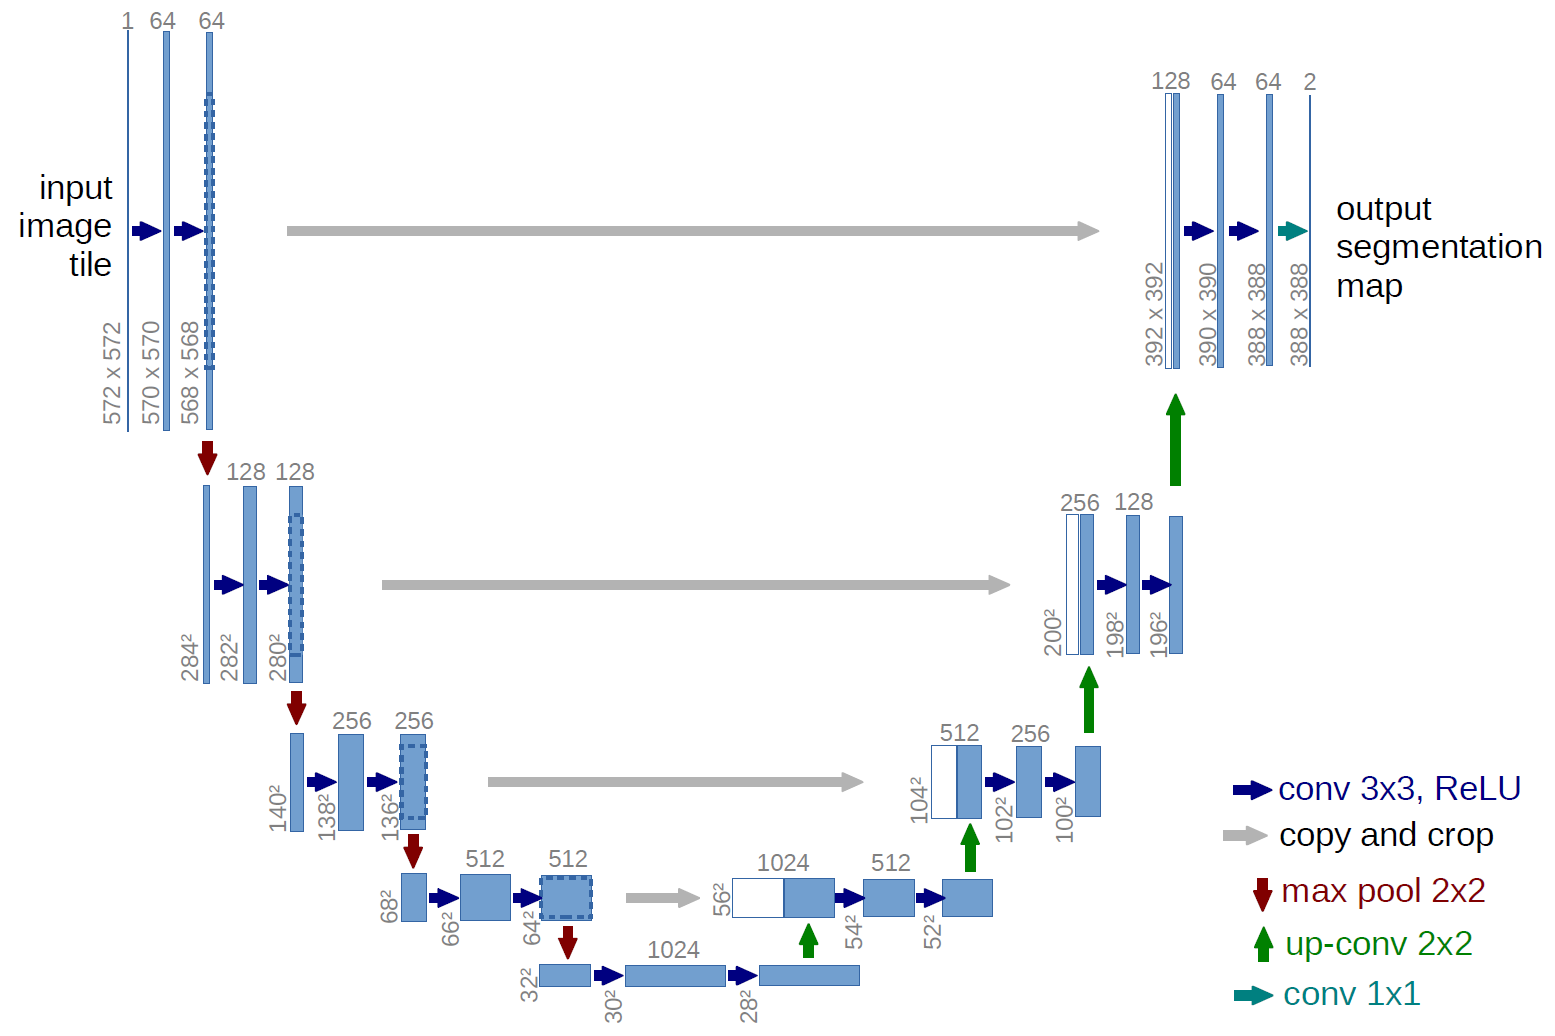

In [7]:
Image("../input/unet-architecture/u-net-architecture.png")

The MobileNetv2 archictecture is described below :

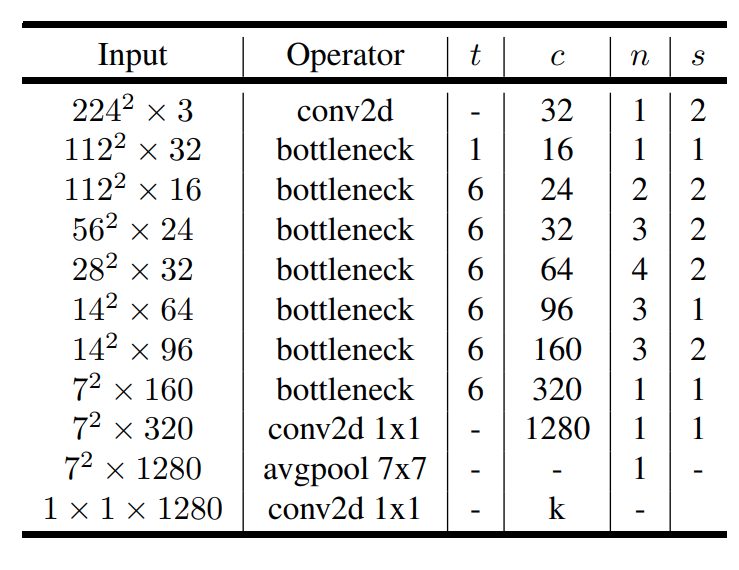

In [8]:
Image("../input/mobile-net-architecture/MobileNetV2 architecture.png")

Creation of the Dataset for the autoencoder model :

In [ ]:
train_x = []
train_y = []
for images in defect_pics_load.values():
    for image in images:
        im_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        train_x.append(im_preprocessed)
        train_y.append(im_preprocessed)
dataset = tf.data.Dataset.from_tensor_slices((np.array(train_x), np.array(train_y))).repeat().batch(64)

**Auto-encoder model**

We reproduce the decoder part of the U-Net architecture described above. To find the skip connections we could use the model_summary and take all the expand_relu of each blocks corresponding to the architecture. I used sigmoid function because my goal is just to see if we are able to find the area defected has the same shape as the input part even if I could use a softmax function because the pictures are not completely white and black.

In [ ]:
def autoencoder():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)0
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

model = autoencoder()

Metrics

In [ ]:
metrics = [BinaryCrossentropy(), Recall(), Precision()]
model.compile(loss=BinaryCrossentropy(), optimizer=tf.keras.optimizers.Nadam(LR), metrics=metrics)


Training

In [ ]:
train_steps = len(train_x)//BATCH
if len(train_x) % BATCH != 0:
    train_steps += 1

model.fit(dataset,epochs=100, steps_per_epoch=train_steps)

Now, we could use our model for some predictions and check if the model is able to rebuild the pictures fed by the model by using the encoder ouputs. I tried with the 100th sample (arbitrary) and I found that the image was quite similar to the input picture. So, our goal is almost reached at this point ! 

In [ ]:
model.save('saved_model/autoencoder')
new_model = tf.keras.models.load_model('saved_model/autoencoder')

In [ ]:
y_pred = new_model.predict(np.expand_dims(train_x[100], axis=0))[0] > 0.5
plt.figure() 
imagesf=[train_x[100],train_y[100],y_pred[:,:,0]]
for im in imagesf:
    plt.figure()
    plt.imshow(im)

**Visualization part**

We begin by extracting the output of the encoder. Then, we will use T-SNE to obtain our representation of clusters. 

In [ ]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
encoder_output = encoder.get_layer("block_13_expand_relu").output
output_encoder_model = tf.keras.Model(inputs=encoder.input, outputs=encoder_output)
encoder_output_final = output_encoder_model(train_x)
model_tsne = TSNE(n_components = 2, random_state = 0)
data = np.array(encoder_output_final[0]).flatten()
data = np.reshape(data, (1,12288))
data = pd.DataFrame(data)
for i in range(1,len(train_x)):
    encoder_out_np = np.array(encoder_output_final[i])
    encoder_out = encoder_out_np.flatten()
    encoder_out = np.reshape(encoder_out, (1,12288))
    encoder_out = pd.DataFrame(encoder_out)
    data = pd.concat([data, encoder_out])
tsne_points = model_tsne.fit_transform(data)
tsne_df = pd.DataFrame(data = tsne_points, columns=["X","Y"])
sns.scatterplot(data = tsne_df,x="X",y="Y")

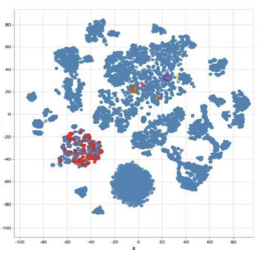

In [6]:
Image("../input/resultattsne/Capture.PNG")

With this representation, we could use a simple classification algorithm to classify our pictures. Thank you very much for your attention ! Feel free to contact me by email : awbenabdi@gmail.com